We first import the openmm package as well as the application and unit module.

In [13]:
import openmm
from openmm import app, unit

We grab a very toyish system---alanine dipeptide (which is one of the simplest system all computational biophysicists use) and save as a [PDB](https://www.rcsb.org/docs/programmatic-access/file-download-services) file. 

In [39]:
import urllib
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/openmm/openmm/master/wrappers/python/tests/systems/alanine-dipeptide-explicit.pdb",
    "input.pdb"
)

We can then read this file into the memory:

In [59]:
pdb = app.PDBFile('input.pdb')

Now we have defined the structure of the system, we define the force field with which we will simulate it.
In this case it's the [Amber14](http://ambermd.org) force field alongside with [TIP3P](https://pubs.acs.org/doi/10.1021/jp003020w) water model.
Note that water molecules are already included for the input this time;
in the next example we'll ask you to manually add that.

In [61]:
forcefield = app.ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')

With everything defined, we can go ahead and create the system, with [particle mesh Ewald](https://en.wikipedia.org/wiki/Ewald_summation) as the nonbonded method.

In [62]:
system = forcefield.createSystem(
    pdb.topology, 
    nonbondedMethod=app.PME,
    nonbondedCutoff=1*unit.nanometer, 
    constraints=app.HBonds,
)

Next, we specify an integrator:

In [42]:
integrator = openmm.LangevinIntegrator(
    300*unit.kelvin, 
    1.0/unit.picoseconds, 
    2.0*unit.femtoseconds
)

It's now time to put everything together to form a simulation object.

In [43]:
simulation = app.Simulation(pdb.topology, system, integrator)

In [44]:
simulation.context.setPositions(pdb.positions)

In [45]:
simulation.minimizeEnergy()

In [46]:
simulation.reporters.append(app.PDBReporter('output.pdb', 10))

In [47]:
simulation.step(100)

In [48]:
import mdtraj as md
traj = md.load('output.pdb')

In [49]:
import nglview
view = nglview.show_mdtraj(traj)

In [50]:
md.compute_J3_HN_C(traj);
md.density(traj);
md.shrake_rupley(traj);

Text(0, 0.5, 'RMSD (nm)')

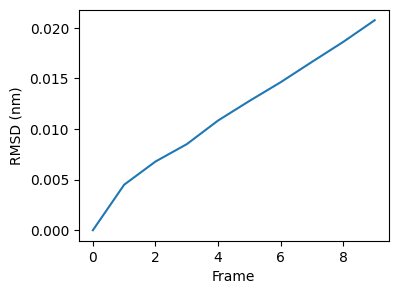

In [58]:
from matplotlib import pyplot as plt
rmsd = md.rmsd(traj, traj, 0)
plt.figure(figsize=(4, 3))
plt.plot(rmsd)
plt.xlabel('Frame')
plt.ylabel('RMSD (nm)')